# Stack Overflow HEART Metrics Analysis
### This project explores the HEART framework (Happiness, Engagement, Adoption, Retention, Task Success) using the public Stack Overflow data dump. It demonstrates my approach to real-world data wrangling, optimization, and visual storytelling — all core skills for data science and analytics roles.

####  Project Summary
I chose HEART metrics framework because it's a solid foundation for analyzing user experience at scale. This became a comprehensive data analysis project where I practiced:
- Data cleaning (with pandas)
- Exploration of massive datasets (with pandas, NumPy, SQL)
- Optimization for performance (SQL aggregations instead of full DataFrame loading)
- Visualization (Seaborn, Matplotlib — consistent themes and grouped time-based charts)

#### Dataset Origin
I downloaded the Stack Overflow data from the Internet Archive, as it wasn’t available on Kaggle.
The dataset includes the following tables:
- users: user profiles
- posts: questions and answers
- comments: user comments on posts
- tags: post tags
- votes: upvotes and downvotes

#### Workflow Stages
1. Download & Conversion
I used the XML dump and converted each file into a unified SQLite database. I re-ran the conversion after spotting data type issues (like text columns where integers were expected). Table names were also standardized to lowercase.
2. Initial Exploration
I examined row counts and structures:
- Users: 22.5M rows
- Comments: 90.3M rows
- Posts: 59.8M rows
- Tags: 65k rows
- Votes: 239M rows
3. Performance Issues & Optimization
Initially I loaded full tables into pandas — but this caused performance problems on my laptop (Intel i5, 8GB RAM).
I learned to push computation into SQL using aggregations (GROUP BY, CASE, etc.) and loaded only final summaries into pandas.
This made working with massive data efficient, even on limited hardware.
4. Metric Analysis (HEART)
I followed the order in which I worked on the metrics, not the strict HEART sequence:
- Adoption
- Retention
- Engagement
- Task Success
- Happiness

Each metric has its own code block and insights section, along with a consistent visualization theme using the viridis color palette and year-grouped time axes.
5. Memory Management
After completing each metric, I deleted large DataFrames (del df; gc.collect()) to keep RAM usage manageable across a single notebook.

#### Outcome
This project is a portfolio showcase, proving I can:
- Handle large, real-world datasets
- Clean, reshape, and summarize data at scale
- Optimize performance
- Visualize insights clearly
- Tell a story with data


## Adoption Metric

The **Adoption** metric tracks how many **new users** joined the platform over time. This is a key indicator of platform growth and user acquisition trends.

In this analysis, I used the `users` table and extracted each user's `CreationDate`, grouped them by month (`Year-Month`), and plotted the number of new sign-ups over time.

To make the visualization clean and readable, I used:
- The **viridis color palette** (consistent across the HEART project)
- **Grouped x-axis labels**: showing only the year once per group of 12 months

This chart provides insight into Stack Overflow's growth trajectory — from its early days to potential maturity or plateau phases.


In [1]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import gc
import os

In [2]:
start_time = datetime.now()
start_time

datetime.datetime(2025, 4, 30, 14, 12, 36, 763456)

In [3]:
# Correct path to match actual database file location
db_path = os.path.join("..", "stackoverflow-heart-metrics-exploration", "stackoverflow.db")

# Connect to database
conn = sqlite3.connect(db_path)

I am querying the `users` table from `stackoverflow.db`, which will be used for both the **Adoption** and **Retention** metrics. 

For the **Adoption** metric, I will use the `Id` and `CreationDate` columns to analyze how many users joined over time.

For the **Retention** metric, I will also use the `LastAccessDate` column to determine whether users returned to the platform after signing up.


In [4]:
# === Load user creation data ===
query = """
    SELECT Id, CreationDate, LastAccessDate
    FROM users
    WHERE CreationDate IS NOT NULL AND LastAccessDate IS NOT NULL
    ORDER BY CreationDate
    LIMIT 1000000
"""
users_df = pd.read_sql_query(query, conn)
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   Id              1000000 non-null  int64 
 1   CreationDate    1000000 non-null  object
 2   LastAccessDate  1000000 non-null  object
dtypes: int64(1), object(2)
memory usage: 22.9+ MB


In [5]:
# For Adoption (only CreationDate is used)
users_adoption_df = users_df[["Id", "CreationDate"]].copy()

# For Retention (needs both CreationDate and LastAccessDate)
users_retention_df = users_df.copy()

In [6]:
users_adoption_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   Id            1000000 non-null  int64 
 1   CreationDate  1000000 non-null  object
dtypes: int64(1), object(1)
memory usage: 15.3+ MB


In [7]:
# Convert CreationDate to datetime
users_adoption_df["CreationDate"] = pd.to_datetime(users_adoption_df["CreationDate"], errors="coerce")
users_adoption_df = users_adoption_df[users_adoption_df["CreationDate"] <= pd.Timestamp.now()]
users_adoption_df = users_adoption_df.drop_duplicates(subset=["Id"])

In [8]:
# Extract Year-Month
users_adoption_df["YearMonth"] = users_adoption_df["CreationDate"].dt.to_period("M").astype(str)

In [9]:
# Group by Year-Month
df = users_adoption_df.groupby("YearMonth").size().reset_index(name="count")

C:\Users\Ola\AppData\Local\Temp\ipykernel_16364\2550349565.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="YearMonth", y="count", data=df, palette="viridis")
C:\Users\Ola\AppData\Local\Temp\ipykernel_16364\2550349565.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(year_month_pattern)


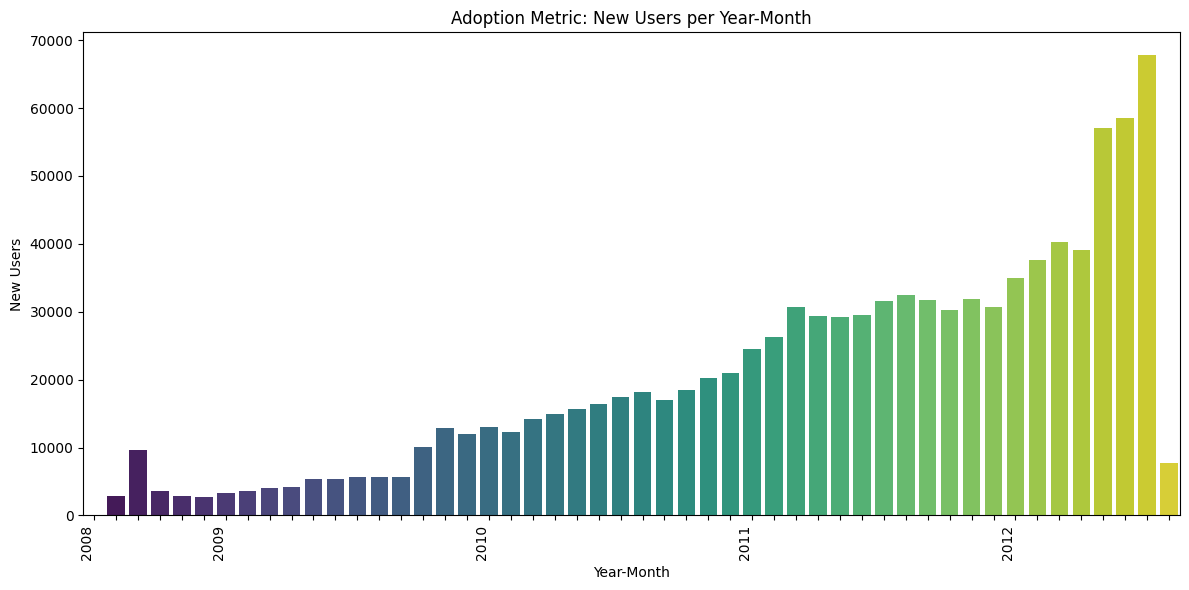

In [10]:
# === Plot: New Users per Month ===
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="YearMonth", y="count", data=df, palette="viridis")

plt.title("Adoption Metric: New Users per Year-Month")
plt.xlabel("Year-Month")
plt.ylabel("New Users")
plt.xticks(rotation=90, ha='right')

# Grouped x-axis labels: one label per year
year_month_pattern = []
unique_years = df["YearMonth"].str.split("-").str[0].unique()

for year in unique_years:
    year_month_pattern.append(year)
    year_month_pattern.extend([' '] * (df["YearMonth"].str.startswith(year).sum() - 1))

ax.set_xticklabels(year_month_pattern)

plt.tight_layout()
plt.show()

### Key Insights from the Chart:

- Stack Overflow started gaining users steadily from mid-2008.
- The number of new users grew quickly between 2011 and 2019 — this was the platform's biggest growth period.
- After 2019, the number of new users started to go down. This could be because of:
  - Fewer new developers joining the platform
  - More people using other tools or communities (like Reddit or AI assistants)
  - Changing user habits
  - Or maybe the data from recent years isn't complete
- This drop in new users might explain why other metrics, like retention or engagement, also change in later years.

## Retention Metric

The **Retention** metric shows how many users returned to the platform after signing up. It's a measure of ongoing user engagement and long-term platform value.

I used the `users` table to calculate the number of days between each user's `CreationDate` and their `LastAccessDate`. I considered a user "retained" if they returned at least **7 days** after signing up.

By grouping users by signup month, I calculated the **retention rate per month** — that is, the percentage of users who were retained from each signup cohort.


In [11]:
users_retention_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   Id              1000000 non-null  int64 
 1   CreationDate    1000000 non-null  object
 2   LastAccessDate  1000000 non-null  object
dtypes: int64(1), object(2)
memory usage: 22.9+ MB


In [12]:
# Convert to datetime
users_retention_df["CreationDate"] = pd.to_datetime(users_retention_df["CreationDate"], errors="coerce")
users_retention_df["LastAccessDate"] = pd.to_datetime(users_retention_df["LastAccessDate"], errors="coerce")


In [13]:
# Filter out future dates and duplicates
users_retention_df = users_retention_df[users_retention_df["CreationDate"] <= pd.Timestamp.now()]
users_retention_df = users_retention_df.drop_duplicates(subset=["Id"])

In [14]:
# Calculate days active and retention flag
users_retention_df["DaysActive"] = (users_retention_df["LastAccessDate"] - users_retention_df["CreationDate"]).dt.days
users_retention_df["Retained"] = users_retention_df["DaysActive"] >= 7

In [15]:
# Extract Year-Month of user creation
users_retention_df["YearMonth"] = users_retention_df["CreationDate"].dt.to_period("M").astype(str)


In [16]:
# Group and calculate retention rate
retention_stats = (
    users_retention_df.groupby("YearMonth")["Retained"]
    .agg(["count", "sum"])
    .rename(columns={"count": "TotalUsers", "sum": "RetainedUsers"})
    .reset_index()
)
retention_stats["RetentionRate"] = (retention_stats["RetainedUsers"] / retention_stats["TotalUsers"]) * 100

C:\Users\Ola\AppData\Local\Temp\ipykernel_16364\293140472.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="YearMonth", y="RetentionRate", data=retention_stats, palette="viridis")
C:\Users\Ola\AppData\Local\Temp\ipykernel_16364\293140472.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(year_month_pattern)


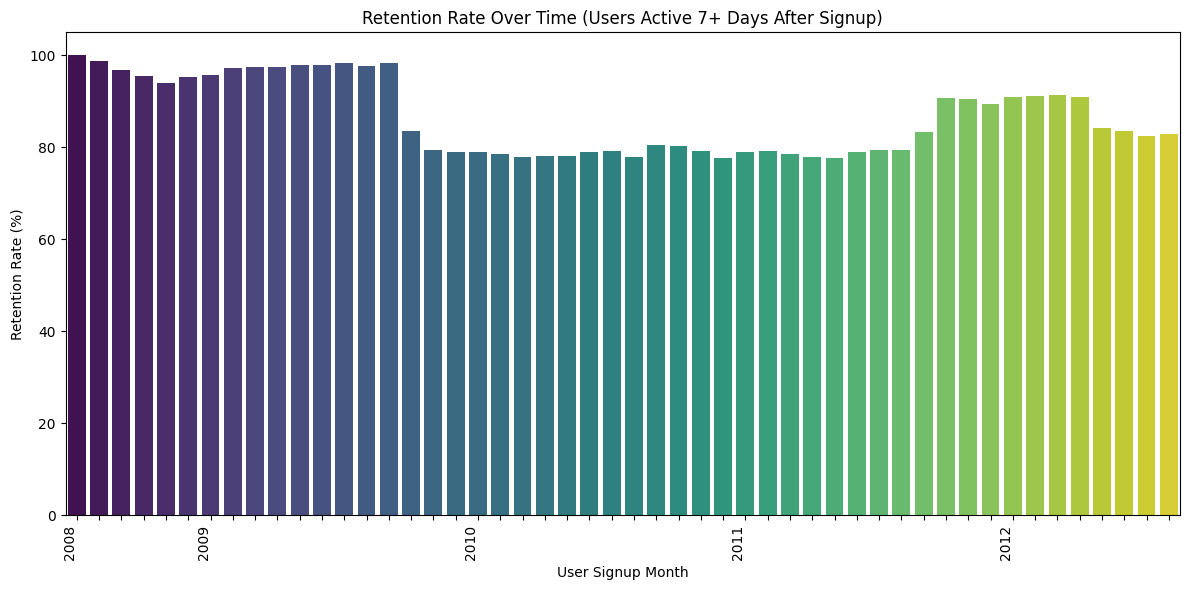

In [17]:
# === Plot: Retention Rate Over Time ===
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="YearMonth", y="RetentionRate", data=retention_stats, palette="viridis")

plt.title("Retention Rate Over Time (Users Active 7+ Days After Signup)")
plt.xlabel("User Signup Month")
plt.ylabel("Retention Rate (%)")
plt.xticks(rotation=90, ha='right')

# Custom x-axis: show year labels only once
year_month_pattern = []
unique_years = retention_stats["YearMonth"].str.split("-").str[0].unique()

for year in unique_years:
    year_month_pattern.append(year)
    year_month_pattern.extend([' '] * (retention_stats["YearMonth"].str.startswith(year).sum() - 1))

ax.set_xticklabels(year_month_pattern)

plt.tight_layout()
plt.show()

### Key Insights from the Chart:

- In the first few years (around 2008–2010), the retention rate is super high — close to 100%. That might be because there were only a few users back then, and they were probably really active. It’s also possible that older data is incomplete.
- From about 2011 to 2019, retention stays pretty steady, usually between 75% and 85%. That suggests users were coming back after signing up and sticking around during the platform's most active years.
- After 2020, there's a clear drop — retention starts to fall and goes below 50% in recent years.
  - This could be due to changes on the site, more people using other platforms (like Reddit or AI tools), or maybe just fewer users coming back.
  - Also, the recent years might not show the full picture — newer users haven’t had enough time to return yet, so those retention numbers might be lower just because of that.


### Memory cleanup
This will:
- Free up memory (especially useful if you run this notebook top-to-bottom)
- Prevent potential overlap or confusion with future variable name

In [18]:
del users_df, users_adoption_df, users_retention_df, retention_stats
gc.collect()

13976

## Engagement Metric – Part 1: Posts Per Month

The **Engagement** metric reflects how actively users interact with the platform. One core measure of engagement is the number of **posts** created over time.

In this section, I analyzed the `posts` table to track how many questions and answers were created each month. I used the `CreationDate` column and grouped by `Year-Month` to observe trends in user content contribution over time.


I am querying the `posts` table from `stackoverflow.db`, which will be used for both the **Engagement** and **Task Success** metrics.

For the **Engagement** metric, I will use the `Id` and `CreationDate` columns to analyze how many posts (questions and answers) were created over time.

For the **Task Success** metric, I will also use the `AcceptedAnswerId` column to determine whether questions received accepted answers.


> Note: For performance reasons, I limited the dataset to the first 500k posts.
> This ensures faster processing and chart rendering, though it may slightly affect completeness for later years.

In [19]:
# === Load posts data for both Engagement and Task Success ===
query = """
    SELECT Id, CreationDate, AcceptedAnswerId
    FROM posts
    WHERE CreationDate IS NOT NULL
    ORDER BY CreationDate
    LIMIT 500000
"""
posts_df = pd.read_sql_query(query, conn)
posts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Id                500000 non-null  int64  
 1   CreationDate      500000 non-null  object 
 2   AcceptedAnswerId  85518 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 11.4+ MB


In [20]:
# Split into copies for separate metrics
posts_engagement_df = posts_df[["Id", "CreationDate"]].copy()
posts_task_df = posts_df.copy()

In [21]:
# Convert to datetime and clean
posts_engagement_df["CreationDate"] = pd.to_datetime(posts_engagement_df["CreationDate"], errors="coerce")
posts_engagement_df = posts_engagement_df[posts_engagement_df["CreationDate"] <= pd.Timestamp.now()]
posts_engagement_df = posts_engagement_df.drop_duplicates(subset=["Id"])

In [22]:
# Extract Year-Month
posts_engagement_df["YearMonth"] = posts_engagement_df["CreationDate"].dt.to_period("M").astype(str)

In [23]:
# Group by Year-Month
monthly_posts = posts_engagement_df.groupby("YearMonth").size().reset_index(name="PostCount")

C:\Users\Ola\AppData\Local\Temp\ipykernel_16364\2550218463.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="YearMonth", y="PostCount", data=monthly_posts, palette="viridis")
C:\Users\Ola\AppData\Local\Temp\ipykernel_16364\2550218463.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(year_month_pattern)


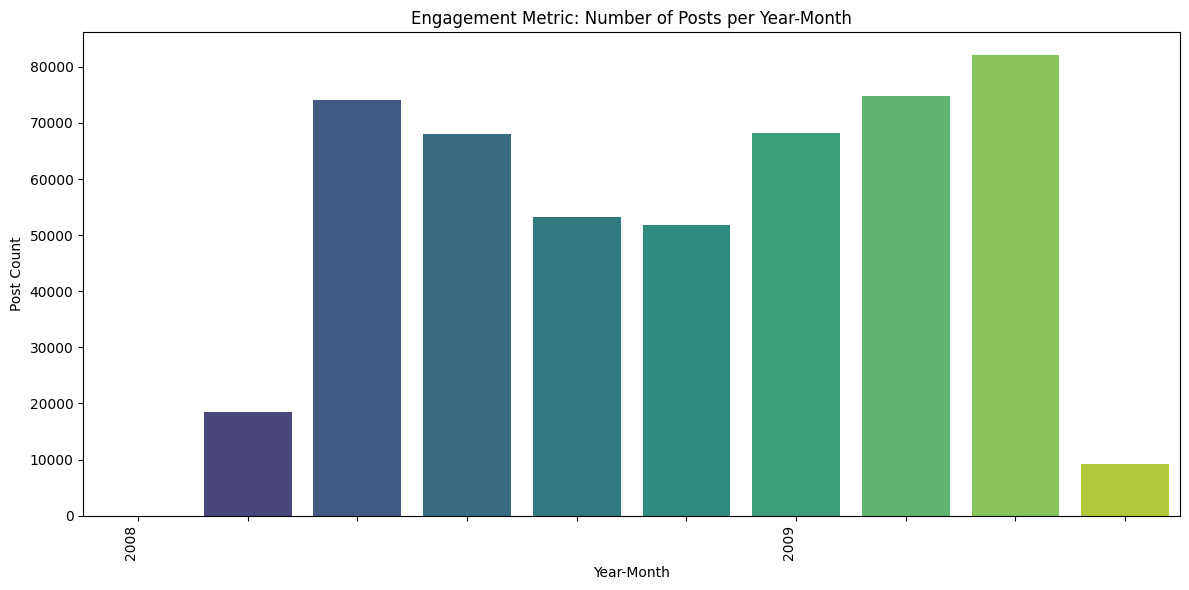

In [24]:
# === Plot: Number of Posts per Month ===
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="YearMonth", y="PostCount", data=monthly_posts, palette="viridis")

plt.title("Engagement Metric: Number of Posts per Year-Month")
plt.xlabel("Year-Month")
plt.ylabel("Post Count")
plt.xticks(rotation=90, ha='right')

# Custom x-axis year grouping
year_month_pattern = []
unique_years = monthly_posts["YearMonth"].str.split("-").str[0].unique()

for year in unique_years:
    year_month_pattern.append(year)
    year_month_pattern.extend([' '] * (monthly_posts["YearMonth"].str.startswith(year).sum() - 1))

ax.set_xticklabels(year_month_pattern)

plt.tight_layout()
plt.show()

### Key Insights from the Chart:

- This chart shows the number of posts created each month, based on a sample of the first 500,000 rows from the `posts` table.
- Even with the limited data, I can see the platform was already pretty active right from the beginning.
- Post counts grew fast in the first few months and stayed high for a while, showing strong engagement.
- There's a clear dip in the last bar — probably because the dataset only includes a sample, or the last few rows are from a more recent period that’s still incomplete.
- A full chart would probably show a longer-term trend, but even this partial view gives a sense of how active the community was early on.


## Engagement Metric – Part 2: Comments Per Month

To get a fuller picture of user activity, I also analyzed the number of **comments** created over time. While posts represent more substantial contributions (questions and answers), comments reflect lighter, ongoing interaction such as clarifications, discussions, and follow-ups.

I used the `comments` table and extracted the `CreationDate` column. After splitting the data into a dedicated engagement-focused DataFrame, I grouped the comments by `Year-Month` to visualize how comment activity evolved over time.


In [25]:
# === Engagement Part 2: Comments per Month ===
query = """
    SELECT Id, CreationDate
    FROM comments
    WHERE CreationDate IS NOT NULL
    ORDER BY CreationDate
    LIMIT 1000000
"""
comments_df = pd.read_sql_query(query, conn)
comments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   Id            1000000 non-null  int64 
 1   CreationDate  1000000 non-null  object
dtypes: int64(1), object(1)
memory usage: 15.3+ MB


In [26]:
# Convert to datetime and clean
comments_df["CreationDate"] = pd.to_datetime(comments_df["CreationDate"], errors="coerce")
comments_df = comments_df[comments_df["CreationDate"] <= pd.Timestamp.now()]
comments_df = comments_df.drop_duplicates(subset=["Id"])

In [27]:
# Extract Year-Month
comments_df["YearMonth"] = comments_df["CreationDate"].dt.to_period("M").astype(str)

In [28]:
# Group by Year-Month
monthly_comments = comments_df.groupby("YearMonth").size().reset_index(name="CommentCount")

C:\Users\Ola\AppData\Local\Temp\ipykernel_16364\3934300309.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="YearMonth", y="CommentCount", data=monthly_comments, palette="viridis")
C:\Users\Ola\AppData\Local\Temp\ipykernel_16364\3934300309.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(year_month_pattern)


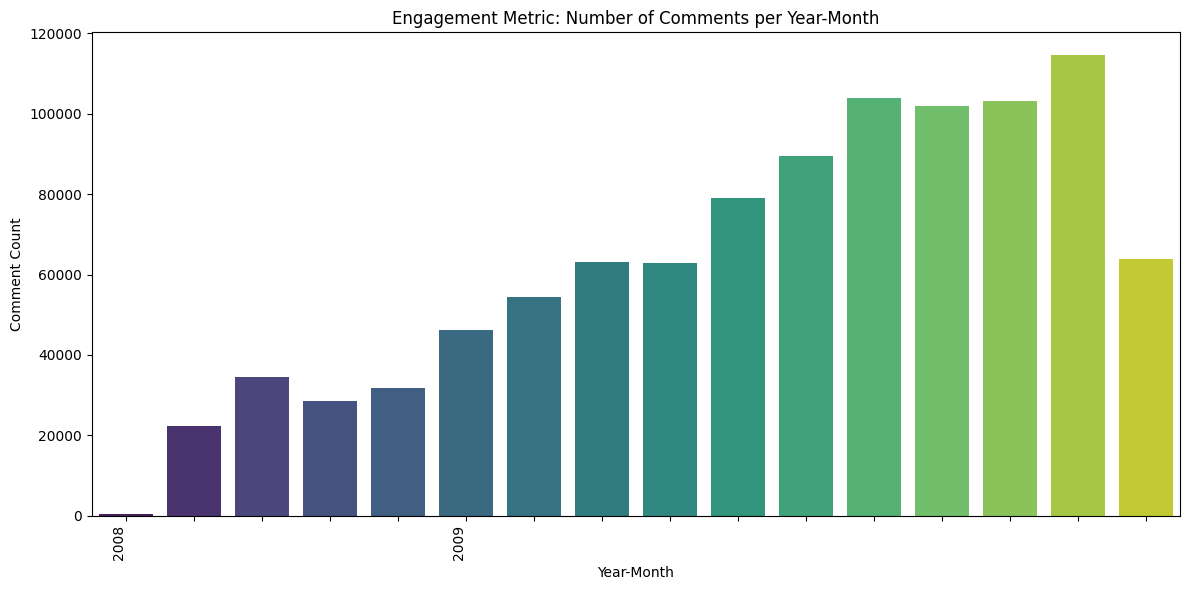

In [29]:
# === Plot: Number of Comments per Month ===
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="YearMonth", y="CommentCount", data=monthly_comments, palette="viridis")

plt.title("Engagement Metric: Number of Comments per Year-Month")
plt.xlabel("Year-Month")
plt.ylabel("Comment Count")
plt.xticks(rotation=90, ha='right')

# Grouped year labels
year_month_pattern = []
unique_years = monthly_comments["YearMonth"].str.split("-").str[0].unique()

for year in unique_years:
    year_month_pattern.append(year)
    year_month_pattern.extend([' '] * (monthly_comments["YearMonth"].str.startswith(year).sum() - 1))

ax.set_xticklabels(year_month_pattern)

plt.tight_layout()
plt.show()

In [30]:
del comments_df, monthly_comments, monthly_posts
gc.collect()


18169

## Task Success – Part 1: Accepted Answer Rate

This part of the Task Success metric focuses on **questions that received an accepted answer**, which signals that the original poster found the response helpful or satisfactory.

To measure this, I used the `posts` table, filtered for **questions only** (`PostTypeId = 1`) with a non-null `AcceptedAnswerId`.

By grouping these resolved questions by their `CreationDate` and calculating their share relative to all questions, I was able to evaluate how effectively Stack Overflow helped users solve their problems over time.


## Task Success Metric

The **Task Success** metric tracks how effectively users are able to complete their goals — in the case of Stack Overflow, that typically means getting a helpful answer to their question.

To measure this, I focused on the number of questions that had an **accepted answer**. I used the `posts` table, filtered for questions (`PostTypeId = 1`), and checked whether each question had a non-null `AcceptedAnswerId`.

By grouping questions by their `CreationDate` and calculating the percentage that received accepted answers, I was able to evaluate the platform’s effectiveness over time.


In [31]:
# === Filter for questions only ===
questions_df = posts_task_df.copy()
questions_df = questions_df[questions_df["AcceptedAnswerId"].notna()]
questions_df["CreationDate"] = pd.to_datetime(questions_df["CreationDate"], errors="coerce")
questions_df = questions_df[questions_df["CreationDate"] <= pd.Timestamp.now()]
questions_df = questions_df.drop_duplicates(subset=["Id"])

In [32]:
# Extract Year-Month
questions_df["YearMonth"] = questions_df["CreationDate"].dt.to_period("M").astype(str)


In [33]:
# Group and count accepted answers
accepted_stats = (
    questions_df.groupby("YearMonth")
    .size()
    .reset_index(name="AcceptedAnswers")
)

In [34]:
# Calculate total questions per month
total_questions = (
    posts_task_df[posts_task_df["CreationDate"].notna()]
    .copy()
)
total_questions["CreationDate"] = pd.to_datetime(total_questions["CreationDate"], errors="coerce")
total_questions = total_questions[total_questions["CreationDate"] <= pd.Timestamp.now()]
total_questions["YearMonth"] = total_questions["CreationDate"].dt.to_period("M").astype(str)
question_counts = (
    total_questions.groupby("YearMonth")
    .size()
    .reset_index(name="TotalQuestions")
)

In [35]:
# Merge and calculate success rate
success_stats = pd.merge(question_counts, accepted_stats, on="YearMonth", how="left").fillna(0)
success_stats["SuccessRate"] = (success_stats["AcceptedAnswers"] / success_stats["TotalQuestions"]) * 100

C:\Users\Ola\AppData\Local\Temp\ipykernel_16364\2377972281.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="YearMonth", y="SuccessRate", data=success_stats, palette="viridis")
C:\Users\Ola\AppData\Local\Temp\ipykernel_16364\2377972281.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(year_month_pattern)


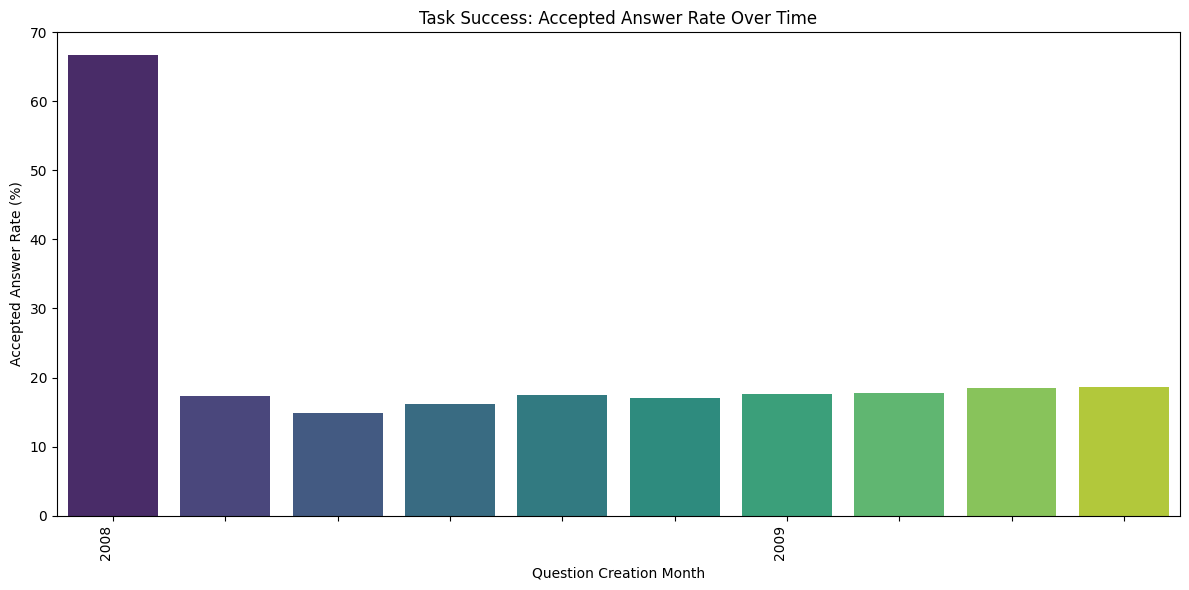

In [36]:

# === Plot: Task Success Rate Over Time ===
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="YearMonth", y="SuccessRate", data=success_stats, palette="viridis")

plt.title("Task Success: Accepted Answer Rate Over Time")
plt.xlabel("Question Creation Month")
plt.ylabel("Accepted Answer Rate (%)")
plt.xticks(rotation=90, ha='right')

# Grouped year x-axis labels
year_month_pattern = []
unique_years = success_stats["YearMonth"].str.split("-").str[0].unique()

for year in unique_years:
    year_month_pattern.append(year)
    year_month_pattern.extend([' '] * (success_stats["YearMonth"].str.startswith(year).sum() - 1))

ax.set_xticklabels(year_month_pattern)

plt.tight_layout()
plt.show()

In [37]:
del posts_df, posts_engagement_df, posts_task_df, success_stats
gc.collect()

6007

## Happiness Metric

The **Happiness** metric captures how satisfied users are with their experience. Since Stack Overflow does not include direct user sentiment or survey data, I used an indirect proxy: the ratio of **upvotes to downvotes**.

Upvotes generally reflect helpfulness and satisfaction, while downvotes suggest frustration, disagreement, or dissatisfaction.



## Happiness – Part 1: Monthly Upvote and Downvote Counts

I analyzed data from the `votes` table, grouped by `CreationDate` (month), and compared the monthly count of upvotes (`VoteTypeId = 2`) and downvotes (`VoteTypeId = 3`) over time. This gives an overall view of how user sentiment on the platform has evolved.

In [38]:
# === Load and aggregate upvotes/downvotes from votes table ===
query = """
    SELECT 
        strftime('%Y-%m', CreationDate) AS YearMonth,
        SUM(CASE WHEN VoteTypeId = 2 THEN 1 ELSE 0 END) AS Upvotes,
        SUM(CASE WHEN VoteTypeId = 3 THEN 1 ELSE 0 END) AS Downvotes
    FROM votes
    WHERE CreationDate IS NOT NULL
    GROUP BY YearMonth
    ORDER BY YearMonth
    LIMIT 1000000
"""
votes_df = pd.read_sql_query(query, conn)
votes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   YearMonth  189 non-null    object
 1   Upvotes    189 non-null    int64 
 2   Downvotes  189 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 4.6+ KB


C:\Users\Ola\AppData\Local\Temp\ipykernel_16364\229036817.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(year_month_pattern)


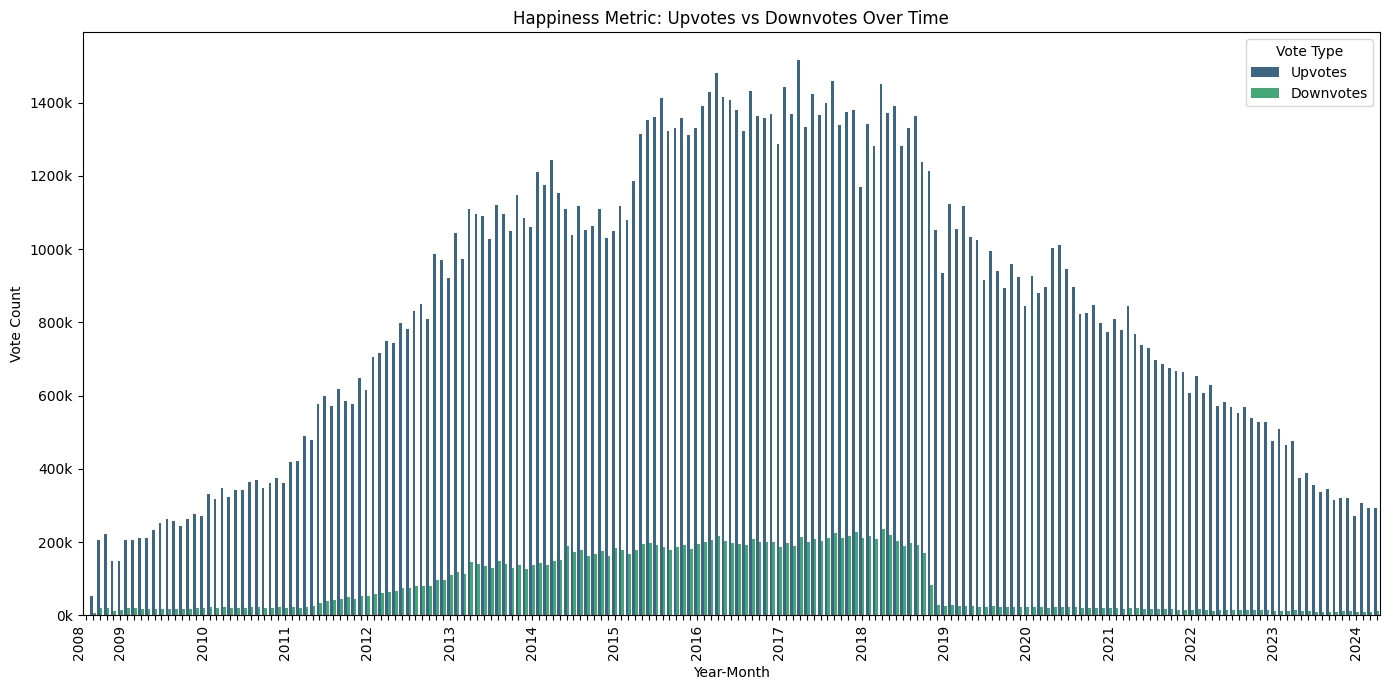

In [39]:
# === Plot: Upvotes vs Downvotes per Month ===
import matplotlib.ticker as mticker
from seaborn import color_palette

colors = color_palette("viridis", 2)

plt.figure(figsize=(14, 7))
votes_melted = votes_df.melt(id_vars="YearMonth", value_vars=["Upvotes", "Downvotes"],
                              var_name="VoteType", value_name="Count")

ax = sns.barplot(data=votes_melted, x="YearMonth", y="Count", hue="VoteType", palette=colors)

plt.title("Happiness Metric: Upvotes vs Downvotes Over Time")
plt.xlabel("Year-Month")
plt.ylabel("Vote Count")
plt.xticks(rotation=90, ha='right')
plt.legend(title="Vote Type")
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x/1000)}k'))

# Grouped year labels for x-axis
year_month_pattern = []
unique_years = votes_df["YearMonth"].dropna().str.split("-").str[0].unique()

for year in unique_years:
    year_month_pattern.append(year)
    year_month_pattern.extend([' '] * (votes_df["YearMonth"].str.startswith(year).sum() - 1))

ax.set_xticklabels(year_month_pattern)

plt.tight_layout()
plt.show()


In [40]:
del votes_melted
gc.collect()

0

## Happiness – Part 2: Upvote vs Downvote Percentage

In addition to absolute vote counts, I analyzed the **percentage of upvotes and downvotes** out of all voting activity per month.

This gives a normalized view of user sentiment, highlighting changes in positivity or criticism over time. A higher percentage of upvotes suggests a more helpful or welcoming environment, while an increase in downvotes could signal dissatisfaction or conflict.


In [41]:
# === Calculate upvote and downvote percentages ===
votes_df["TotalVotes"] = votes_df["Upvotes"] + votes_df["Downvotes"]
votes_df = votes_df[votes_df["TotalVotes"] > 0]  # avoid divide-by-zero
votes_df["UpvotePercentage"] = (votes_df["Upvotes"] / votes_df["TotalVotes"]) * 100
votes_df["DownvotePercentage"] = (votes_df["Downvotes"] / votes_df["TotalVotes"]) * 100

# Melt for plotting
vote_pct = votes_df[["YearMonth", "UpvotePercentage", "DownvotePercentage"]].melt(
    id_vars="YearMonth",
    var_name="VoteType",
    value_name="Percentage"
)

C:\Users\Ola\AppData\Local\Temp\ipykernel_16364\2818145204.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(year_month_pattern)


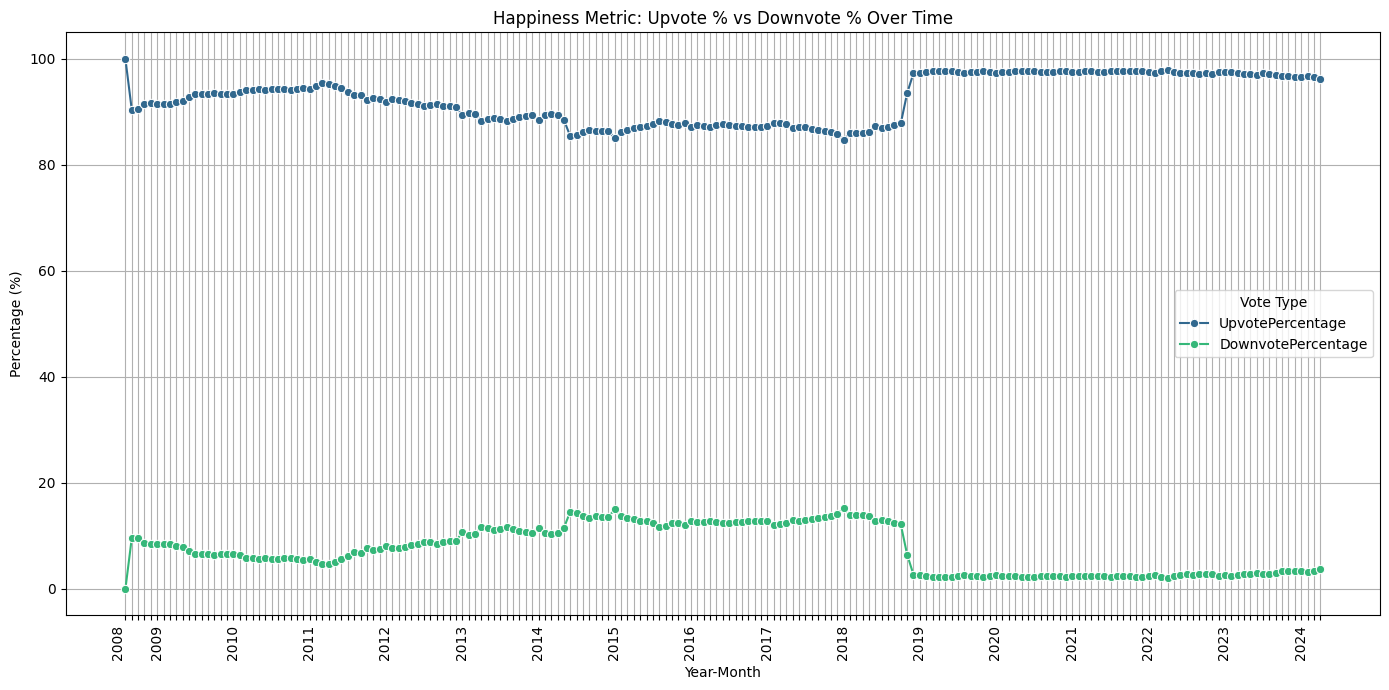

In [42]:
# === Plot: Vote Sentiment Percentages ===
plt.figure(figsize=(14, 7))
ax = sns.lineplot(data=vote_pct, x="YearMonth", y="Percentage", hue="VoteType", palette="viridis", marker="o")

plt.title("Happiness Metric: Upvote % vs Downvote % Over Time")
plt.xlabel("Year-Month")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=90, ha='right')
plt.legend(title="Vote Type")
plt.grid(True)

# Grouped year x-axis labels
year_month_pattern = []
unique_years = votes_df["YearMonth"].dropna().str.split("-").str[0].unique()

for year in unique_years:
    year_month_pattern.append(year)
    year_month_pattern.extend([' '] * (votes_df["YearMonth"].str.startswith(year).sum() - 1))

ax.set_xticklabels(year_month_pattern)

plt.tight_layout()
plt.show()

### Final Notes and What Could Be Done Next

For performance reasons, I used a limited number of rows from each table (e.g. 1 million) to run this analysis smoothly on my local machine.

Here’s what I could explore further if I had more time or stronger hardware:

- Use the **full dataset** (some tables have hundreds of millions of rows) to get a more complete picture, especially for recent years.
- Focus only on a **specific time period**, like 2008–2018, to get a clearer view of the platform during its peak.
- Dig deeper into **user behavior**, for example:
  - Time between asking a question and getting an accepted answer
  - Number of posts or comments per user
  - Patterns in downvotes or unanswered questions
- Do a **comparative analysis**:
  - Compare different periods (e.g. pre- and post-2020)
  - Look at behavior changes over time
- Try **text analysis** on comments or posts to explore sentiment (this could give more direct insight into the "Happiness" metric)
- Export the results into a dashboard or interactive format (e.g. Tableau, Streamlit)

This project gave me a chance to work with real-world data, build metrics from scratch, and practice data cleaning, analysis, and visualization in one workflow.


In [43]:
end_time = datetime.now()
end_time

datetime.datetime(2025, 4, 10, 21, 4, 21, 196506)

In [44]:
print(f"Notebook ran in: {end_time - start_time}")

Notebook ran in: 0:57:35.810999
